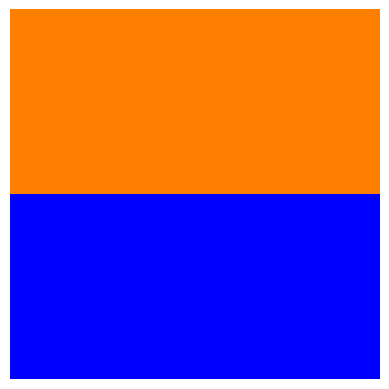

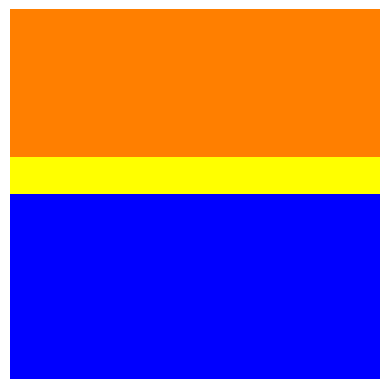

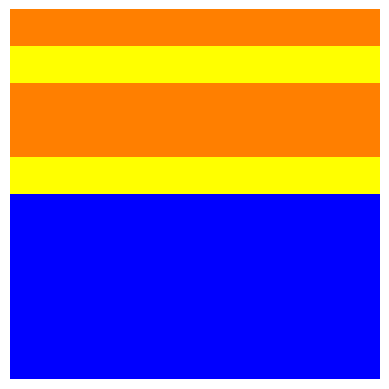

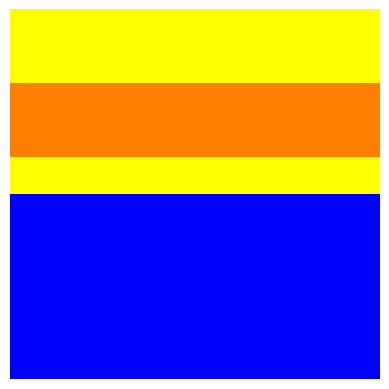

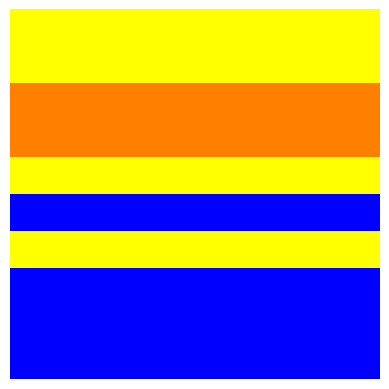

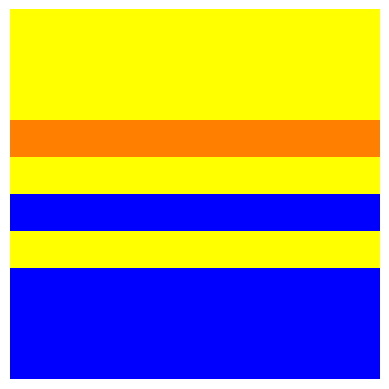

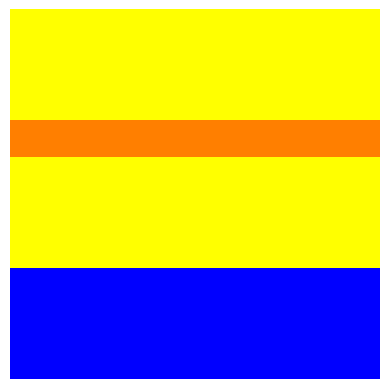

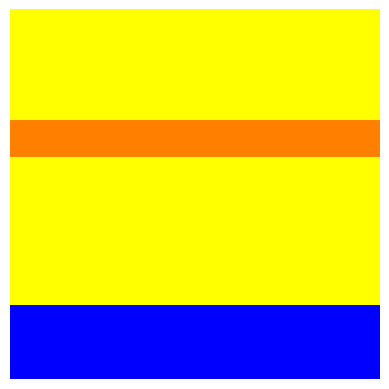

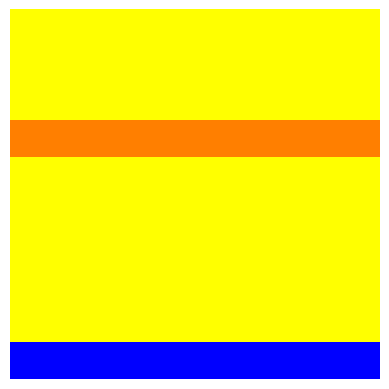

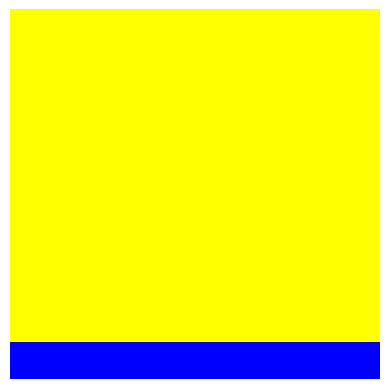

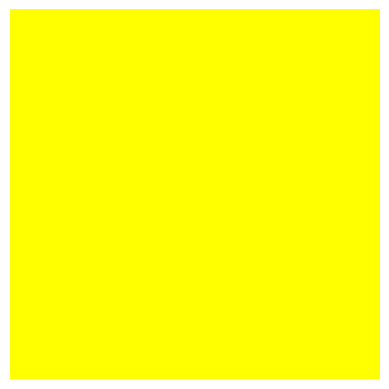

Silhouette Scores:
0.9393488189514961
0.8675205890936896
0.8266536617189356
0.7683195430544917
0.7367845620708015
0.700616854145903
0.634999352870306
0.6273563528110792
0.6436646372691837

Entropy Scores:
0.004621561179774192
0.01418496282108006
0.057316810744507674
0.018546104966346344
0.023499531242175853
0.004621561179774192
0.004621561179774192
0.0
0.0

Calinski Harabasz Scores:
3146.2148636707407
1185.0313221501376
835.0739208393543
614.4811967195615
489.29496108671657
421.5392155943674
316.64366189566766
307.7326721073857
323.1299182277667

Davies-Bouldin Scores:
10.483294337505031
4.909109377704649
3.65076079776198
2.9714371606432803
2.5895731557562303
2.3930947091495094
2.0188445125215444
2.037226711943488
2.0932729662378455

Dunn-Index Scores:
0.44636646353090237
0.08973447830777591
0.08973447830777591
0.08973447830777591
0.06877794321397505
0.06877794321397505
0.0655233493073624
0.0655233493073624
0.06877794321397505

Gap Scores:
1.3959982425542434
1.0777045882942424
1.262797

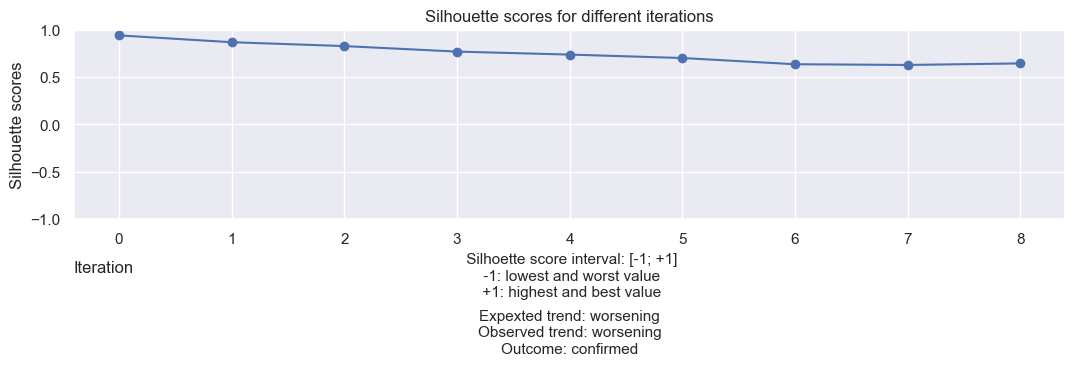

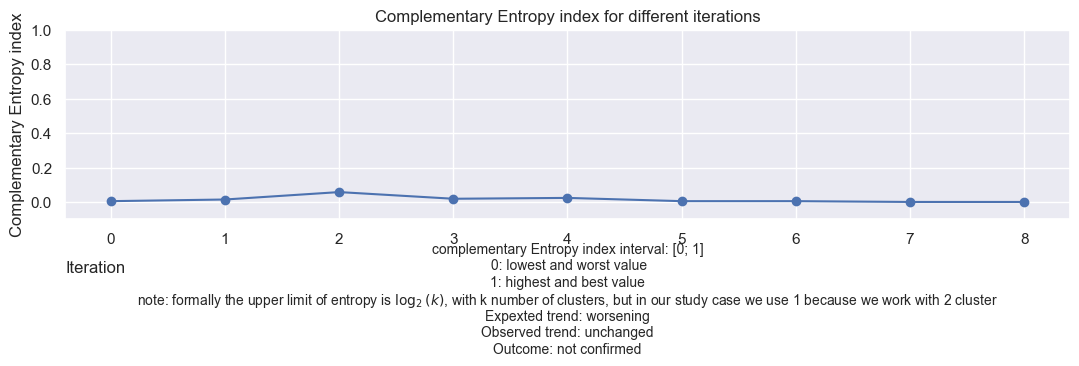

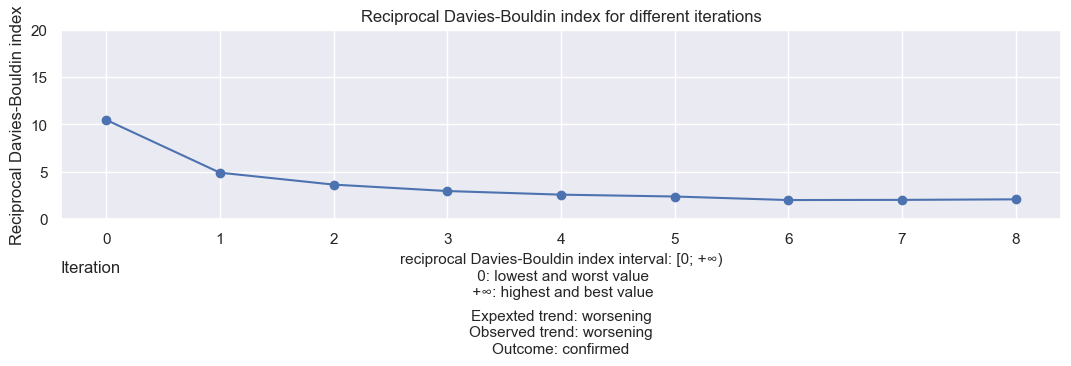

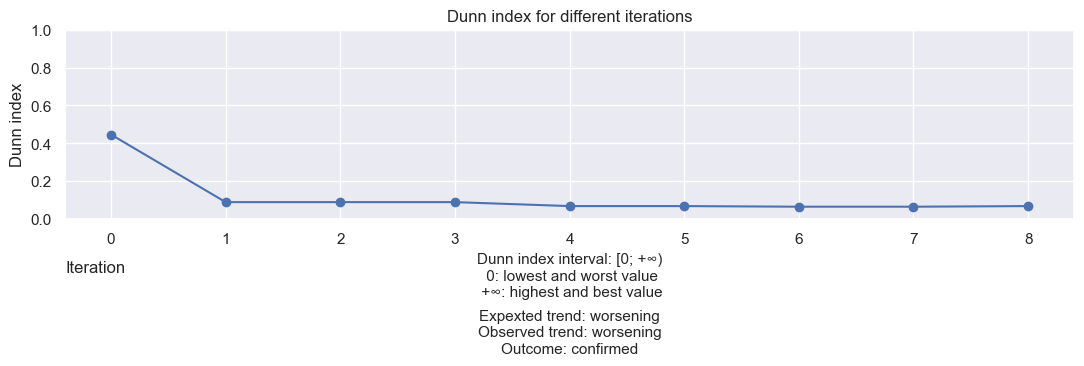

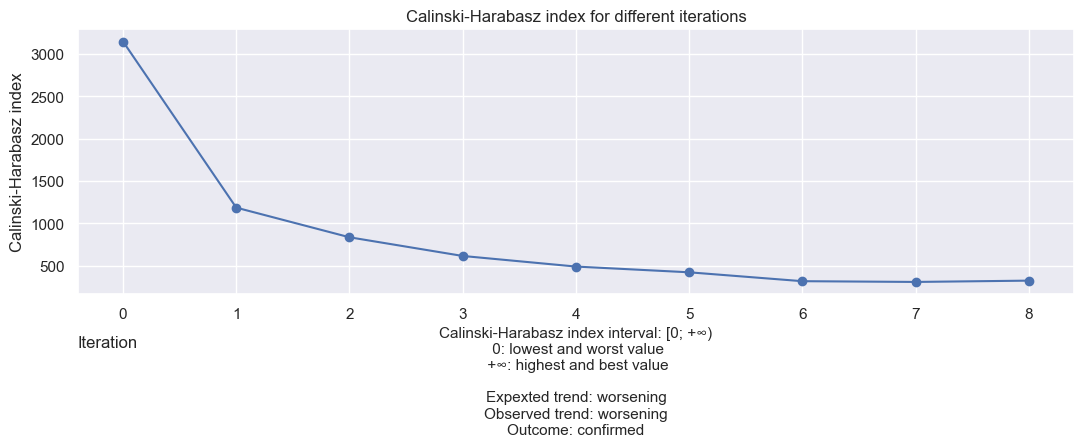

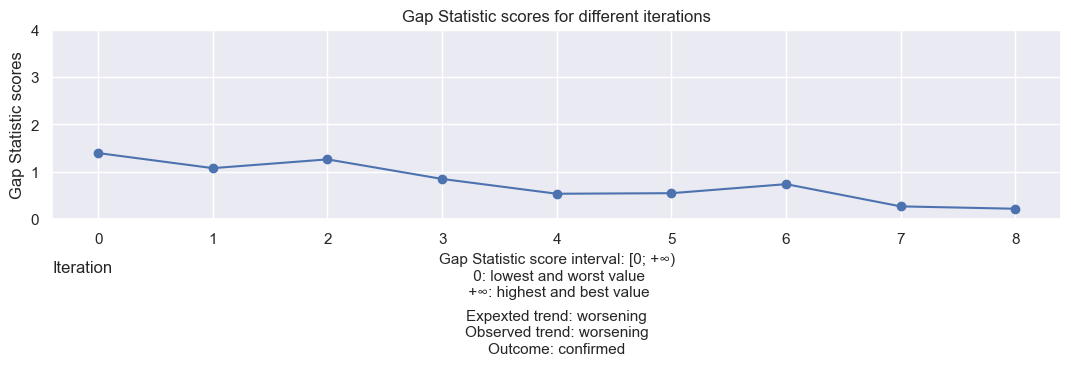

metric,result,time
Silhouette,correct,0.0006831884384155273 s
Entropy,correct,0.00023586750030517577 s
Davies-Bouldin,correct,0.0001871347427368164 s
Dunn index,correct,0.00045914649963378905 s
Calinski-Harabasz,wrong,0.00029821395874023436 s
Gap Statistic,wrong,0.032905864715576175 s


Report:
I expect the metrics to get worse as more rows changed. This happened with all the metrics except Entropy which always remains constant


In [30]:
import random
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import time
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import pandas as pd

#library for Entropy calculation
from scipy.stats import entropy

#library for Calinski-Harabasz score calculation
from sklearn.metrics import calinski_harabasz_score

#library for davies_bouldin score calculation
from sklearn.metrics import davies_bouldin_score

#library for table style
from IPython.display import display, HTML

from gap_statistic import OptimalK
from sklearn.metrics import pairwise_distances

#function for dunn_index score calculation
def dunn_index(X, labels):
    unique_labels = np.unique(labels)
    min_intercluster_distance = np.inf
    max_intracluster_diameter = -np.inf

    for i in range(len(unique_labels)):
        for j in range(i + 1, len(unique_labels)):
            cluster_i_points = X[labels == unique_labels[i]]
            cluster_j_points = X[labels == unique_labels[j]]
            
            # Calculate the minimum distance between clusters
            intercluster_distance = np.min(pairwise_distances(cluster_i_points, cluster_j_points))
            min_intercluster_distance = min(min_intercluster_distance, intercluster_distance)

        # Calculate the maximum intra-cluster diameter
        intracluster_diameter = np.max(pairwise_distances(X[labels == unique_labels[i]]))
        max_intracluster_diameter = max(max_intracluster_diameter, intracluster_diameter)
    
        return min_intercluster_distance / max_intracluster_diameter

#set plot style with default seaborn style
sns.set()

silhouette_scores = []  
entropy_scores = []
calinski_harabasz_scores = []
davies_bouldin_scores = []
dunn_index_scores = [] 
gap_scores = []

tempo_di_calcolo_silhouette = 0
tempo_di_calcolo_entropy = 0
tempo_di_calcolo_calinski_harabasz = 0
tempo_di_calcolo_davies_bouldin = 0
tempo_di_calcolo_dunn_index = 0
tempo_di_calcolo_gap = 0

#variable for metric trend
silhouette_appo = 0
entropy_appo = 0
calinski_harabasz_appo = 0
davies_bouldin_appo = 0
dunn_index_appo = 0
gap_appo = 0


def color_matrix(matrix):
    colored_matrix = np.zeros(matrix.shape + (3,), dtype=float)

    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            if matrix[i, j] == 0:
                colored_matrix[i, j] = [1, 0.5, 0]  # Arancione
            elif matrix[i, j] == 1:
                colored_matrix[i, j] = [0, 0, 1]  # Blu
            elif 0 < matrix[i, j] < 1:
                colored_matrix[i, j] = [1, 1, 0]  # Giallo
            else:
                colored_matrix[i, j] = [1, 1, 1]  # Bianco come valore predefinito

    return colored_matrix

#create matrix 
n=10
matrice = np.zeros((n, n))
meta=n//2
matrice[meta:] = 1

righe_da_modificare = list(range(n))
trovato=0
count = 0

colored_matrix = color_matrix(matrice)
plt.imshow(np.zeros_like(matrice), cmap='gray')  
plt.imshow(colored_matrix, cmap='rainbow', interpolation='nearest')  
plt.axis('off')
plt.show()

i=0

# Add random numbers to cells containing 0 in the zero_array
while righe_da_modificare:
    indice_riga = random.choice(righe_da_modificare)
    righe_da_modificare.remove(indice_riga)
    
       # Transform the zero_matrix into a numpy array and then into a vector
    vector = np.array(matrice).flatten()

    # Apply the K-Means algorithm with k=2
    kmeans = KMeans(n_clusters=2, n_init=2, random_state=10)
    kmeans.fit(vector.reshape(-1, 1))  
    # Get cluster labels
    l= kmeans.labels_

    tempi_di_calcolo = np.empty((6, 10))

    if i>0:
        start_time = time.time()
        silhouette_avg = silhouette_score(vector.reshape(-1, 1), l)
        silhouette_scores.append(silhouette_avg)
        end_time = time.time()
        tempo_di_calcolo = end_time - start_time
        tempo_di_calcolo_silhouette = tempo_di_calcolo_silhouette + tempo_di_calcolo
        
        start_time = time.time()
        entropy_val = entropy(np.bincount(l) / len(l), base=2)
        entropy_val = abs(1 - entropy_val)
        entropy_scores.append(entropy_val)
        end_time = time.time()
        tempo_di_calcolo = end_time - start_time
        tempo_di_calcolo_entropy = tempo_di_calcolo_entropy + tempo_di_calcolo
        
        start_time = time.time()
        calinski_harabasz_index = calinski_harabasz_score(vector.reshape(-1, 1), l)
        calinski_harabasz_scores.append(calinski_harabasz_index)
        end_time = time.time()
        tempo_di_calcolo = end_time - start_time
        tempo_di_calcolo_calinski_harabasz = tempo_di_calcolo_calinski_harabasz + tempo_di_calcolo
        
        start_time = time.time()
        davies_bouldin_avg = davies_bouldin_score(vector.reshape(-1, 1), l)
        davies_bouldin_avg = 1 / davies_bouldin_avg
        davies_bouldin_scores.append(davies_bouldin_avg)
        end_time = time.time()
        tempo_di_calcolo = end_time - start_time
        tempo_di_calcolo_davies_bouldin = tempo_di_calcolo_davies_bouldin + tempo_di_calcolo
        
        start_time = time.time()
        dunn_score = dunn_index(vector.reshape(-1, 1), l)
        dunn_index_scores.append(dunn_score)
        end_time = time.time()
        tempo_di_calcolo = end_time - start_time
        tempo_di_calcolo_dunn_index = tempo_di_calcolo_dunn_index + tempo_di_calcolo
        
        start_time = time.time()
        optimal_k = OptimalK(parallel_backend='joblib')
        n_clusters = optimal_k(vector.reshape(-1, 1), cluster_array=np.arange(1, 15))
        gap_df = optimal_k.gap_df
        optimal_gap_statistic = gap_df.loc[gap_df.gap_value.idxmax(), 'gap_value']
        gap_scores.append(optimal_gap_statistic)
        end_time = time.time()
        tempo_di_calcolo = end_time - start_time
        tempo_di_calcolo_gap = tempo_di_calcolo_gap + tempo_di_calcolo
    i+=1

    
    for j in range(n):
        if matrice[indice_riga, j] == 0 or matrice[indice_riga, j] == 1:
            matrice[indice_riga, j] = random.random()
            trovato = trovato + 1
    
    if trovato > 0:
        colored_matrix = color_matrix(matrice)
        count = count +1

        plt.imshow(np.zeros_like(matrice), cmap='gray')  
        plt.imshow(colored_matrix, cmap='rainbow', interpolation='nearest')  
        plt.axis('off')  # Rimuove gli assi
        plt.show()        

    trovato=0
    
print("Silhouette Scores:")
for score in silhouette_scores:
    print(score)

print("\nEntropy Scores:")
for score in entropy_scores:
    print(score)
    
print("\nCalinski Harabasz Scores:")
for score in calinski_harabasz_scores:
    print(score)

print("\nDavies-Bouldin Scores:")
for score in davies_bouldin_scores:
    print(score)
    
print("\nDunn-Index Scores:")
for score in dunn_index_scores:
    print(score)
    
print("\nGap Scores:")
for score in gap_scores:
    print(score)

# Save metric values to a txt file
with open("/Users/andreaspagnolo/Desktop/uni/stage/result/result_matrix/metrics_values_matrix.txt", "w") as file:
    file.write("Silhouette Scores:\n")
    for score in silhouette_scores:
        file.write(str(score) + "\n")

    file.write("\nEntropy Scores:\n")
    for score in entropy_scores:
        file.write(str(score) + "\n")

    file.write("\nCalinski Harabasz Scores:\n")
    for score in calinski_harabasz_scores:
        file.write(str(score) + "\n")

    file.write("\nDavies-Bouldin Scores:\n")
    for score in davies_bouldin_scores:
        file.write(str(score) + "\n")

    file.write("\nDunn-Index Scores:\n")
    for score in dunn_index_scores:
        file.write(str(score) + "\n")

    file.write("\nGap Scores:\n")
    for score in gap_scores:
        file.write(str(score) + "\n")
    
iteration_indices = list(range(len(silhouette_scores)))
    
# Plot of Silhouette variations
plt.figure(figsize=(11, 5))
plt.plot(iteration_indices, silhouette_scores, marker='o')
plt.title('Silhouette scores for different iterations')
plt.xlabel('Iteration', labelpad=10, loc='left')
plt.ylabel('Silhouette scores')
text = ' Silhoette score interval: [-1; +1]\n -1: lowest and worst value\n +1: highest and best value'
plt.text(0.5, -0.3, text, ha='center', va='center', transform=plt.gca().transAxes,fontsize=11)
text2='Expexted trend: worsening\nObserved trend: worsening\nOutcome: confirmed'
plt.text(0.5, -0.6, text2, ha='center', va='center', transform=plt.gca().transAxes,fontsize=11)
plt.grid(True)
file_path = '/Users/andreaspagnolo/Desktop/uni/stage/result/result_matrix/variazioni_Silhouette_matrix.png'
plt.ylim(-1, 1)
plt.tight_layout()
plt.savefig(file_path)
plt.show()

# Plot of Entropy variations
plt.figure(figsize=(11, 5))
plt.plot(iteration_indices, entropy_scores, marker='o')
plt.title('Complementary Entropy index for different iterations')
plt.xlabel('Iteration', labelpad=10, loc='left')
plt.ylabel('Complementary Entropy index')
text='complementary Entropy index interval: [0; 1]\n 0: lowest and worst value\n1: highest and best value\n'+ 'note: formally the upper limit of entropy is $\log_{2}(k)$, with k number of clusters, but in our study case we use 1 because we work with 2 cluster'
plt.text(0.5, -0.3, text, ha='center', va='center', transform=plt.gca().transAxes,fontsize=10)
text2='Expexted trend: worsening\nObserved trend: unchanged\nOutcome: not confirmed'
plt.text(0.5, -0.6, text2, ha='center', va='center', transform=plt.gca().transAxes,fontsize=10)
plt.grid(True)
plt.ylim(-0.1, 1)
file_path = '/Users/andreaspagnolo/Desktop/uni/stage/result/result_matrix/variazioni_Entropy_matrix.png'
plt.tight_layout()
plt.savefig(file_path)
plt.show()

# Plot of Davies_Bouldin variations
plt.figure(figsize=(11, 5))
plt.plot(iteration_indices, davies_bouldin_scores, marker='o')
plt.title('Reciprocal Davies-Bouldin index for different iterations')
plt.xlabel('Iteration', labelpad=10, loc='left')
plt.ylabel('Reciprocal Davies-Bouldin index')
text='reciprocal Davies-Bouldin index interval: [0; +∞)\n 0: lowest and worst value\n +∞: highest and best value'
plt.text(0.5, -0.3, text, ha='center', va='center', transform=plt.gca().transAxes,fontsize=11)
text2='Expexted trend: worsening\nObserved trend: worsening\nOutcome: confirmed'
plt.text(0.5, -0.6, text2, ha='center', va='center', transform=plt.gca().transAxes,fontsize=11)
plt.grid(True)
plt.ylim(0, 20)
plt.tight_layout()
file_path = '/Users/andreaspagnolo/Desktop/uni/stage/result/result_matrix/variazioni_Davies_Bouldin_matrix.png'
plt.savefig(file_path)
plt.show()

# Plot of Dunn_index variations
plt.figure(figsize=(11, 5))
plt.plot(iteration_indices, dunn_index_scores, marker='o')
plt.title('Dunn index for different iterations')
plt.xlabel('Iteration', labelpad=10, loc='left')
plt.ylabel('Dunn index')
text = 'Dunn index interval: [0; +∞)\n 0: lowest and worst value\n +∞: highest and best value' 
plt.text(0.5, -0.3, text, ha='center', va='center', transform=plt.gca().transAxes, fontsize=11)
text2='Expexted trend: worsening\nObserved trend: worsening\nOutcome: confirmed'
plt.text(0.5, -0.6, text2, ha='center', va='center', transform=plt.gca().transAxes,fontsize=11)
plt.grid(True)
plt.ylim(0, 1)
plt.tight_layout()
file_path = '/Users/andreaspagnolo/Desktop/uni/stage/result/result_matrix/variazioni_Dunn_index_matrix.png'
plt.savefig(file_path)
plt.show()

# Plot of Calinski_Harabasz Scores variations
plt.figure(figsize=(11, 5))
plt.plot(iteration_indices, calinski_harabasz_scores, marker='o')
plt.title('Calinski-Harabasz index for different iterations')
plt.xlabel('Iteration', labelpad=10, loc='left')
plt.ylabel('Calinski-Harabasz index')
text='\nCalinski-Harabasz index interval: [0; +∞)\n 0: lowest and worst value\n +∞: highest and best value\n\nExpexted trend: worsening\nObserved trend: worsening\nOutcome: confirmed'
plt.text(0.5, -0.3, text, ha='center', va='center', transform=plt.gca().transAxes,fontsize=11)
plt.grid(True)
plt.tight_layout()
file_path = '/Users/andreaspagnolo/Desktop/uni/stage/result/result_matrix/variazioni_Calinski_Harabasz_matrix.png'
plt.savefig(file_path)
plt.show()

# Plot of Gap Statistic variations
plt.figure(figsize=(11, 5))
plt.plot(iteration_indices, gap_scores, marker='o')
plt.title('Gap Statistic scores for different iterations')
plt.xlabel('Iteration', labelpad=10, loc='left')
plt.ylabel('Gap Statistic scores')
text = 'Gap Statistic score interval: [0; +∞)\n 0: lowest and worst value\n +∞: highest and best value' 
plt.text(0.5, -0.3, text, ha='center', va='center', transform=plt.gca().transAxes, fontsize=11)
text2='Expexted trend: worsening\nObserved trend: worsening\nOutcome: confirmed'
plt.text(0.5, -0.6, text2, ha='center', va='center', transform=plt.gca().transAxes,fontsize=11)
plt.grid(True)
plt.ylim(0, 4)
plt.tight_layout()
file_path = '/Users/andreaspagnolo/Desktop/uni/stage/result/result_matrix/variazioni_Gap_Statistic_matrix.png'
plt.savefig(file_path)
plt.show()

tempo_di_calcolo_silhouette = tempo_di_calcolo_silhouette / n          
tempo_di_calcolo_entropy = tempo_di_calcolo_entropy / n
tempo_di_calcolo_calinski_harabasz = tempo_di_calcolo_calinski_harabasz / n
tempo_di_calcolo_davies_bouldin = tempo_di_calcolo_davies_bouldin / n
tempo_di_calcolo_dunn_index = tempo_di_calcolo_dunn_index / n
tempo_di_calcolo_gap = tempo_di_calcolo_gap / n

for i in range(0,1):
    tempi_di_calcolo[0, i] = tempo_di_calcolo_silhouette
    tempi_di_calcolo[1, i] = tempo_di_calcolo_entropy
    tempi_di_calcolo[2, i] = tempo_di_calcolo_calinski_harabasz
    tempi_di_calcolo[3, i] = tempo_di_calcolo_davies_bouldin
    tempi_di_calcolo[4, i] = tempo_di_calcolo_dunn_index
    tempi_di_calcolo[5, i] = tempo_di_calcolo_gap

medie_colonne = np.mean(tempi_di_calcolo, axis=0)

file_path="/Users/andreaspagnolo/Desktop/uni/stage/result/result_matrix/final_result"
table_df = pd.DataFrame(columns=["metric", "result", "time"])

dati_tabella = [
    ["Silhouette", "correct", str(tempi_di_calcolo[0,0]) + " s"],
    ["Entropy", "correct", str(tempi_di_calcolo[1,0]) + " s"],
    ["Davies-Bouldin", "correct", str(tempi_di_calcolo[2,0]) + " s"],
    ["Dunn index", "correct", str(tempi_di_calcolo[3,0]) + " s"],
    ["Calinski-Harabasz", "wrong", str(tempi_di_calcolo[4,0]) + " s"],
    ["Gap Statistic", "wrong", str(tempi_di_calcolo[5,0]) + " s"]
]


for row_data in dati_tabella:
    table_df.loc[len(table_df)] = row_data
    
#save result in a variable
for riga in dati_tabella:
    if riga[1] == "correct":
        if riga[0] == "Silhouette":
            silhouette_appo += 1
        elif riga[0] == "Entropy":
            entropy_appo += 1
        elif riga[0] == "Calinski-Harabasz":
            calinski_harabasz_appo += 1
        elif riga[0] == "Davies-Bouldin":
            davies_bouldin_appo += 1
        elif riga[0] == "Dunn index":
            dunn_index_appo += 1
        elif riga[0] == "Gap Statistic":
            gap_appo += 1


#table style
table_df.style \
  .format(precision=3, thousands=".", decimal=",").set_properties(**{'text-align': 'left'})

# Save HTML table to file
table_df.to_csv(file_path + ".csv")

html_table = table_df.to_html(index=False, classes="table table-striped", border=0)
html_table = html_table.replace('<table', '<table style="width:100%;" text-align:center;"')
html_table = html_table.replace('<td', '<td style="text-align:center;"').replace('<th', '<th style="text-align:center;"')

#print table
display(HTML(html_table))

print("Report:")
print("I expect the metrics to get worse as more rows changed. This happened with all the metrics except Entropy which always remains constant")
with open("/Users/andreaspagnolo/Desktop/uni/stage/result/result_matrix/report_matrix.txt", "w") as file:
    file.write("Report:\n")
    file.write("I expect the metrics to get worse as more rows changed. This happened with all the metrics except Entropy which always remains constant")
